# ESG Pre-filter Classifier - EDA & Feature Engineering

This notebook focuses on exploratory data analysis and feature engineering for the ESG pre-filter classifier. It compares multiple feature engineering approaches and exports the best transformer for use in model selection.

## Objective
Develop feature engineering pipeline that can distinguish between articles that contain ESG (Environmental, Social, Governance) content vs those that don't.

**Key Insight: This is a recall-focused problem.**
- **Missing an ESG article (low recall) = BAD** - we miss content that should be labeled
- **Letting through a non-ESG article (low precision) = OK** - LLM can skip it later

We optimize for **F2 score** which weights recall 2x higher than precision.

## Contents
1. [Setup](#setup)
2. [Data Loading](#1-data-loading)
3. [Target Variable Analysis](#2-target-variable-analysis) (ALL DATA - for stratification)
4. [Data Preprocessing & Split](#3-data-preprocessing--split)
5. [Exploratory Data Analysis](#4-exploratory-data-analysis) (TRAINING DATA ONLY)
6. [Feature Engineering Comparison](#5-feature-engineering-comparison)
   - 5.1 [Feature Transformer Hyperparameter Tuning](#51-feature-transformer-hyperparameter-tuning)
7. [Pipeline Export](#6-pipeline-export)
8. [Summary](#7-summary)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

# Sklearn imports
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.ep1_nb.data_utils import (
    load_jsonl_data,
    analyze_target_stats,
    split_train_val_test,
)
from src.ep1_nb.eda_utils import (
    analyze_text_length_stats,
    plot_text_length_distributions,
    analyze_brand_distribution,
    plot_brand_distribution,
    analyze_word_frequencies,
)
from src.ep1_nb.preprocessing import (
    clean_text,
    create_text_features,
)
from src.ep1_nb.feature_transformer import EPFeatureTransformer
from src.ep1_nb.modeling import (
    analyze_tuning_results,
    plot_fe_comparison,
    plot_tuning_results,
    tune_feature_transformer,
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
TARGET_COL = 'has_esg'
LABEL_NAMES = ['No ESG', 'Has ESG']
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.6, 0.2, 0.2
RANDOM_STATE = 42
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'ep_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)

np.random.seed(RANDOM_STATE)

print("Setup complete!")

Setup complete!


## 1. Data Loading

In [2]:
# Load the ESG pre-filter training data
df = load_jsonl_data(DATA_PATH)

Loaded 870 records from ep_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'has_esg', 'source', 'skip_reason']
Memory usage: 6.12 MB


In [3]:
# Preview the data
df.head()

,article_id,title,content,brands,source_name,category,has_esg,source,skip_reason
0,62df09ce-8fd1-4139-998a-5e94cfe924ef,The factors behind Lululemon CEO Calvin McDonald departure from the brand,"After seven years as CEO of athleisure giant Lululemon, retail veteran Calvin McDonald announced...",[Lululemon],insideretail.asia,[],1,labeled,NaN
1,c1a8b5eb-fa19-409b-84b2-7fe42af406cf,"I cant think of a place more pristine : 133 , 000 hectares of Chilean Patagonia preserved afte...",A wild valley in Chilean Patagonia has been preserved for future generations and protected from ...,[Patagonia],theguardian.com,[],1,labeled,NaN
2,c10de7db-ddd3-4f2c-b6bb-9704be93649d,Adidas Unveils New Mohamed Salah F50 Elite Boots Ahead of AFCON,"Adidas just dropped a new signature F50 Elite colourway for Mohamed Salah, created in collaborat...",[Adidas],cairoscene.com,[],1,labeled,NaN
3,135068ac-2ef6-4e80-b217-0cc69c74e571,Nike China conundrum deepens as turnaround stagnates – Channel Africa,"The United States (US) sportswear giant’s sixth straight quarterly sales decline in the country,...",[Nike],channelafrica.co.za,[],1,labeled,NaN
4,eaef8add-b935-4f7b-a933-bf72482a9fe3,Patagonia R1 Thermal Hoody Review,"The wind cut across the valley, and snow hissed sideways as I clipped into my Nordic skis for on...",[Patagonia],gearjunkie.com,[],1,labeled,NaN


In [4]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   article_id   870 non-null    object
 1   title        870 non-null    object
 2   content      870 non-null    object
 3   brands       870 non-null    object
 4   source_name  870 non-null    object
 5   category     870 non-null    object
 6   has_esg      870 non-null    int64 
 7   source       870 non-null    object
 8   skip_reason  235 non-null    object
dtypes: int64(1), object(8)
memory usage: 61.3+ KB


In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
article_id       0
title            0
content          0
brands           0
source_name      0
category         0
has_esg          0
source           0
skip_reason    635
dtype: int64


In [6]:
# Examine the source distribution
print("\nSource distribution:")
print(df['source'].value_counts())


Source distribution:
source
labeled    635
skipped    235
Name: count, dtype: int64


## 2. Target Variable Analysis (ALL DATA)

This analysis uses the full dataset to understand class imbalance before splitting. This is necessary to inform our stratification strategy.

TARGET VARIABLE ANALYSIS

Total samples: 870

Class distribution:
  No ESG: 235 (27.0%)
  Has ESG: 635 (73.0%)

Imbalance ratio: 2.70:1

[OK] Dataset is reasonably balanced


Figure saved to images/ep_target_distribution.png


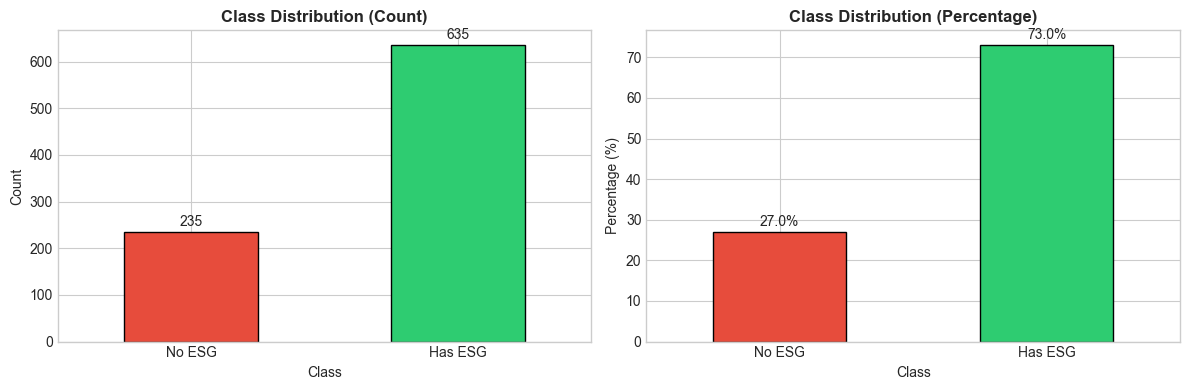

In [7]:
# Analyze target distribution
target_stats = analyze_target_stats(
    df, 
    TARGET_COL, 
    label_names=LABEL_NAMES,
    imbalance_threshold=5.0,
    save_path='images/ep_target_distribution.png'
)

## 3. Data Preprocessing & Train/Val/Test Split

We preprocess the text data first (creating text_features), then split into train/val/test sets. All subsequent EDA and feature engineering will use ONLY the training data to prevent data leakage. The validation dataset is used for feature engineering selection. The test data set is NOT used in this notebook.

In [8]:
# Create text features BEFORE splitting
# This combines title, brands, and content into a single cleaned text field
# Now includes source_name and category for metadata features
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print("Text features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

# Check for empty text features
empty_texts = (df['text_features'].str.len() == 0).sum()
print(f"\nRecords with empty text features: {empty_texts}")
if empty_texts > 0:
    df = df[df['text_features'].str.len() > 0].copy()
    print(f"Remaining records after removing empty: {len(df)}")

Text features created!
Sample:
insideretail.asia the factors behind lululemon ceo calvin mcdonald departure from the brand the factors behind lululemon ceo calvin mcdonald departure from the brand lululemon after seven years as ceo of athleisure giant lululemon retail veteran calvin mcdonald announced he would be leaving the comp...

Records with empty text features: 0


In [9]:
# Split with stratification
train_df, val_df, _ = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    random_state=RANDOM_STATE
)

# Extract features and targets
X_train = train_df['text_features']
y_train = train_df[TARGET_COL]

X_val = val_df['text_features']
y_val = val_df[TARGET_COL]

print(f"\nDataset sizes:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")

TRAIN/VALIDATION/TEST SPLIT

Total samples: 870

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      522 (60.0%)
  Validation: 174 (20.0%)
  Test:       174 (20.0%)

Class distribution (stratified by 'has_esg'):
  Train: 1: 73.0%, 0: 27.0%
  Val: 1: 73.0%, 0: 27.0%
  Test: 1: 73.0%, 0: 27.0%

Dataset sizes:
  Train: 522 samples
  Val:   174 samples


## 4. Exploratory Data Analysis (TRAINING DATA ONLY)

All EDA from this point forward uses ONLY the training data to prevent data leakage.

### 4.1 Text Length Analysis

In [10]:
# Analyze text lengths (TRAINING DATA ONLY)
text_stats = analyze_text_length_stats(train_df, 'content', TARGET_COL)

TEXT LENGTH STATISTICS

Column: 'content'
Total records: 522

Overall statistics:
  Character length: mean=3704, median=2582, range=[140, 52711]
  Word count: mean=600, median=421, range=[22, 8910]

By has_esg:
  Class 0:
    Chars: mean=3149, median=2019
    Words: mean=509, median=328
  Class 1:
    Chars: mean=3910, median=2810
    Words: mean=634, median=451


Figure saved to images/ep_text_length_dist.png


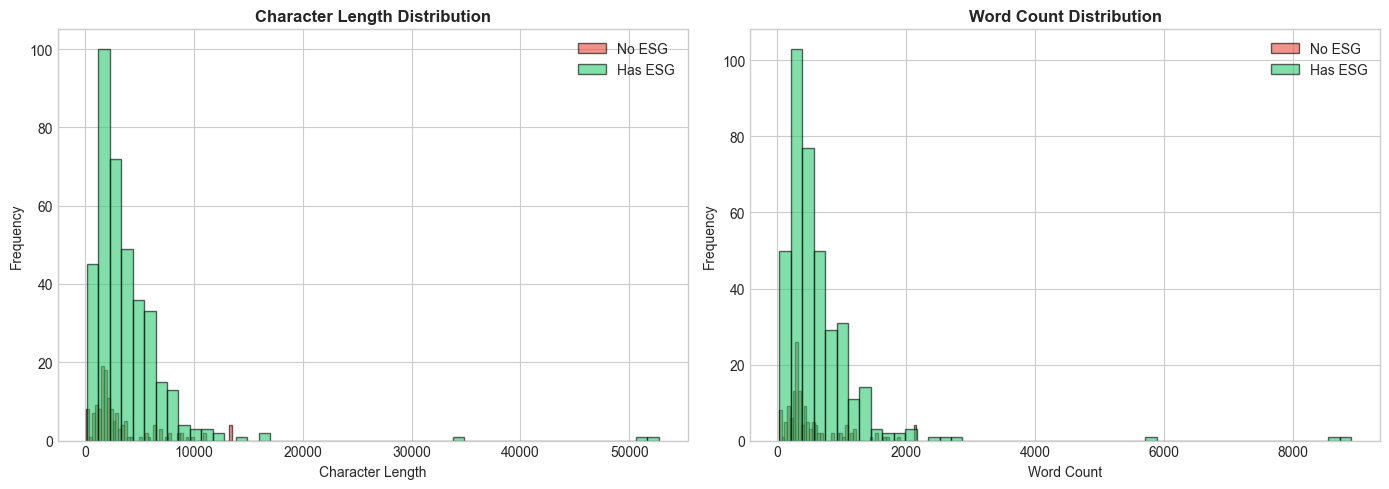

In [11]:
# Plot text length distributions by class (TRAINING DATA ONLY)
plot_text_length_distributions(
    train_df, 'content', TARGET_COL,
    label_names={0: 'No ESG', 1: 'Has ESG'},
    save_path='images/ep_text_length_dist.png'
)

### 4.2 Brand Distribution

In [12]:
# Analyze brand distribution (TRAINING DATA ONLY)
brand_counts = analyze_brand_distribution(train_df, 'brands', TARGET_COL, top_n=15)

BRAND DISTRIBUTION

Total brand mentions: 556
Unique brands: 38

Top 15 brands:
  Nike: 159 (28.6%)
  Lululemon: 74 (13.3%)
  Adidas: 44 (7.9%)
  Hoka: 28 (5.0%)
  Puma: 26 (4.7%)
  Reebok: 21 (3.8%)
  New Balance: 18 (3.2%)
  Skechers: 16 (2.9%)
  Vans: 15 (2.7%)
  Timberland: 15 (2.7%)
  Anta: 13 (2.3%)
  Patagonia: 13 (2.3%)
  Salomon: 12 (2.2%)
  ASICS: 12 (2.2%)
  Converse: 9 (1.6%)

Brand distribution by has_esg:
  Class 0: 158 mentions, top: Nike (49), Adidas (16), Reebok (10)
  Class 1: 398 mentions, top: Nike (110), Lululemon (64), Adidas (28)


Figure saved to images/ep_brand_dist.png


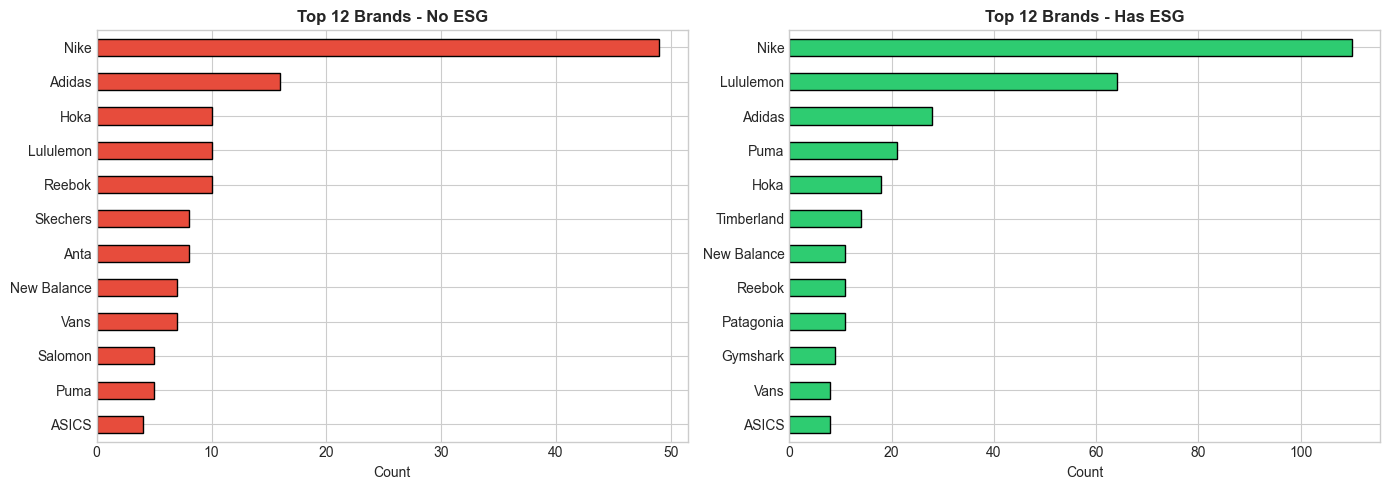

In [13]:
# Plot brand distribution by class (TRAINING DATA ONLY)
plot_brand_distribution(
    train_df, 'brands', TARGET_COL,
    label_names={0: 'No ESG', 1: 'Has ESG'},
    top_n=12,
    figsize=(14, 5),
    save_path='images/ep_brand_dist.png'
)

### 4.3 Word Frequency Analysis

In [14]:
# Analyze word frequencies by class (TRAINING DATA ONLY)
word_freqs = analyze_word_frequencies(train_df, 'content', TARGET_COL, top_n=15)

WORD FREQUENCY ANALYSIS

Top 15 words for class_0:
  nike: 270
  shoe: 207
  running: 195
  out: 175
  market: 175
  sneaker: 164
  shoes: 164
  company: 164
  women: 162
  price: 156
  off: 156
  sale: 155
  stock: 150
  year: 143
  men: 134

Top 15 words for class_1:
  nike: 1,259
  company: 909
  year: 766
  brand: 761
  lululemon: 708
  quarter: 585
  stock: 471
  like: 452
  shares: 442
  out: 423
  running: 407
  growth: 406
  over: 378
  price: 371
  sales: 360


In [15]:
# Look at some non-ESG examples (TRAINING DATA ONLY)
print("\n" + "="*60)
print("SAMPLE NON-ESG ARTICLES (from training data)")
print("="*60)

no_esg_train = train_df[train_df[TARGET_COL] == 0]
if len(no_esg_train) >= 3:
    samples = no_esg_train.sample(3, random_state=RANDOM_STATE)
else:
    samples = no_esg_train

for _, row in samples.iterrows():
    print(f"\nBrands: {row['brands']}")
    print(f"Title: {row['title'][:100]}...")
    if 'skip_reason' in row and pd.notna(row['skip_reason']):
        print(f"Skip Reason: {row['skip_reason']}")
    print("-" * 40)


SAMPLE NON-ESG ARTICLES (from training data)

Brands: ['Adidas']
Title: Jennifer Aniston Favorite Adidas Are Finally on Sale ( for Now ) ...
Skip Reason: No ESG content found
----------------------------------------

Brands: ['The North Face']
Title: The North Face winter jackets are on sale up to 50 % off at REI...
Skip Reason: No ESG content found
----------------------------------------

Brands: ['Vans']
Title: OTW by Vans x S . R . Studio LA . CA . Clog...
Skip Reason: No ESG content found
----------------------------------------


## 5. Feature Engineering Comparison

We compare multiple feature engineering approaches using cross-validation on the training data with baseline classifiers. This helps us select the best approach before moving to model selection in the next notebook.

In [16]:
# Define feature engineering approaches to compare
fe_configs = {
    'tfidf_lsa': {
        'method': 'tfidf_lsa',
        'max_features': 10000,
        'lsa_n_components': 100,
        'include_metadata_features': False,
    },
    'tfidf_lsa_ner_proximity': {
        'method': 'tfidf_lsa_ner_proximity',
        'max_features': 10000,
        'lsa_n_components': 100,
        'proximity_window_size': 15,
        'include_metadata_features': False,
    },
    'sentence_transformer': {
        'method': 'sentence_transformer',
        'sentence_model_name': 'all-MiniLM-L6-v2',
        'include_metadata_features': False,
    },
    'sentence_transformer_ner': {
        'method': 'sentence_transformer_ner',
        'sentence_model_name': 'all-MiniLM-L6-v2',
        'include_metadata_features': False,
    },
    'sentence_transformer_ner_vocab': {
        'method': 'sentence_transformer_ner_vocab',
        'sentence_model_name': 'all-MiniLM-L6-v2',
        'include_metadata_features': False,
    },
}

# Hyperparameter tuning configurations for each method
TUNING_CONFIGS = {
    'tfidf_lsa': {
        'param_name': 'lsa_n_components',
        'param_values': [50, 60, 80, 100, 120, 150, 200],
        'description': 'LSA dimensionality'
    },
    'tfidf_lsa_ner_proximity': {
        'param_name': 'lsa_n_components',
        'param_values': [50, 60, 80, 100, 120, 150, 200],
        'description': 'LSA dimensionality (with NER + proximity)'
    },
    'sentence_transformer_ner': {
        'param_name': 'proximity_window_size',
        'param_values': [10, 15, 20, 25, 30],
        'description': 'NER proximity window size'
    },
    'sentence_transformer_ner_vocab': {
        'param_name': 'proximity_window_size',
        'param_values': [10, 15, 20, 25, 30],
        'description': 'NER+vocab proximity window size'
    },
}

print("Feature Engineering Approaches to Compare:")
print("=" * 50)
for name, config in fe_configs.items():
    print(f"  {name}: {config['method']}")

print("\nTuning configurations defined for:")
for name in TUNING_CONFIGS:
    cfg = TUNING_CONFIGS[name]
    print(f"  {name}: {cfg['param_name']} = {cfg['param_values']}")

Feature Engineering Approaches to Compare:
  tfidf_lsa: tfidf_lsa
  tfidf_lsa_ner_proximity: tfidf_lsa_ner_proximity
  sentence_transformer: sentence_transformer
  sentence_transformer_ner: sentence_transformer_ner
  sentence_transformer_ner_vocab: sentence_transformer_ner_vocab

Tuning configurations defined for:
  tfidf_lsa: lsa_n_components = [50, 60, 80, 100, 120, 150, 200]
  tfidf_lsa_ner_proximity: lsa_n_components = [50, 60, 80, 100, 120, 150, 200]
  sentence_transformer_ner: proximity_window_size = [10, 15, 20, 25, 30]
  sentence_transformer_ner_vocab: proximity_window_size = [10, 15, 20, 25, 30]


In [17]:
# Evaluate each feature engineering approach using cross-validation
# Compare with Logistic Regression, Random Forest, and HistGradientBoosting classifiers
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Define classifiers to benchmark
classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(
            max_iter=2000,
            class_weight=None,
            random_state=RANDOM_STATE,
            solver='lbfgs'
        ),
        'requires_dense': False,
    },
    'RandomForest': {
        'model': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE,
            class_weight='balanced',
            n_jobs=-1
        ),
        'requires_dense': False,
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier(
            max_iter=100,
            max_depth=5,
            class_weight=None,
            random_state=RANDOM_STATE,
        ),
        'requires_dense': True,
    },
}

fe_results = []

for name, config in fe_configs.items():
    print(f"Evaluating {name}...")
    
    # Create transformer
    transformer = EPFeatureTransformer(**config, random_state=RANDOM_STATE)
    
    # Fit and transform training data
    X_train_fe = transformer.fit_transform(X_train)
    
    print(f"  Feature shape: {X_train_fe.shape}, sparse: {sparse.issparse(X_train_fe)}")
    
    # Evaluate with each classifier
    for clf_name, clf_info in classifiers.items():
        clf = clf_info['model']
        
        # Convert to dense if classifier requires it
        if clf_info['requires_dense'] and sparse.issparse(X_train_fe):
            X_for_cv = X_train_fe.toarray()
        else:
            X_for_cv = X_train_fe
        
        # Cross-validation
        cv_scores = cross_validate(
            clf, X_for_cv, y_train,
            cv=cv,
            scoring={
                'f2': f2_scorer,
                'recall': 'recall',
                'precision': 'precision',
            },
            return_train_score=False
        )
        
        result = {
            'name': name,
            'classifier': clf_name,
            'n_features': X_train_fe.shape[1],
            'cv_f2': cv_scores['test_f2'].mean(),
            'cv_f2_std': cv_scores['test_f2'].std(),
            'cv_recall': cv_scores['test_recall'].mean(),
            'cv_precision': cv_scores['test_precision'].mean(),
        }
        fe_results.append(result)
        
        print(f"  [{clf_name}] CV F2: {result['cv_f2']:.4f} (+/- {result['cv_f2_std']:.4f})")

Evaluating tfidf_lsa...


  Feature shape: (522, 100), sparse: False
  [LogisticRegression] CV F2: 0.9355 (+/- 0.0026)


  [RandomForest] CV F2: 0.9029 (+/- 0.0172)


  [HistGradientBoosting] CV F2: 0.8599 (+/- 0.0235)
Evaluating tfidf_lsa_ner_proximity...


  Feature shape: (522, 114), sparse: False
  [LogisticRegression] CV F2: 0.9108 (+/- 0.0140)


  [RandomForest] CV F2: 0.9138 (+/- 0.0198)


  [HistGradientBoosting] CV F2: 0.8689 (+/- 0.0200)
Evaluating sentence_transformer...


  Feature shape: (522, 384), sparse: False
  [LogisticRegression] CV F2: 0.9187 (+/- 0.0083)


  [RandomForest] CV F2: 0.9181 (+/- 0.0049)


  [HistGradientBoosting] CV F2: 0.8882 (+/- 0.0173)
Evaluating sentence_transformer_ner...


  Feature shape: (522, 390), sparse: False
  [LogisticRegression] CV F2: 0.9059 (+/- 0.0102)


  [RandomForest] CV F2: 0.9213 (+/- 0.0088)


  [HistGradientBoosting] CV F2: 0.8854 (+/- 0.0140)
Evaluating sentence_transformer_ner_vocab...


  Feature shape: (522, 401), sparse: False
  [LogisticRegression] CV F2: 0.8905 (+/- 0.0065)


  [RandomForest] CV F2: 0.9185 (+/- 0.0127)


  [HistGradientBoosting] CV F2: 0.8793 (+/- 0.0188)


In [18]:
# Compare feature engineering results
fe_df = pd.DataFrame(fe_results)

# Create pivot table for easier comparison
pivot_df = fe_df.pivot_table(
    index='name',
    columns='classifier',
    values=['cv_f2', 'cv_recall', 'cv_precision'],
    aggfunc='first'
)

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPARISON RESULTS")
print("=" * 80)

# Display results sorted by F2 score for each classifier
for clf_name in ['LogisticRegression', 'RandomForest', 'HistGradientBoosting']:
    clf_df = fe_df[fe_df['classifier'] == clf_name].set_index('name')
    clf_df = clf_df.sort_values('cv_f2', ascending=False)
    print(f"\n{clf_name} Results:")
    print(clf_df[['n_features', 'cv_f2', 'cv_f2_std', 'cv_recall', 'cv_precision']])

print("=" * 80)

# Determine best overall
best_row = fe_df.loc[fe_df['cv_f2'].idxmax()]
best_fe = best_row['name']
best_clf = best_row['classifier']
print(f"\nBest combination: {best_fe} + {best_clf}")
print(f"  CV F2: {best_row['cv_f2']:.4f}")
print(f"  Features: {int(best_row['n_features'])}")


FEATURE ENGINEERING COMPARISON RESULTS

LogisticRegression Results:
                                n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                         
tfidf_lsa                              100  0.935497   0.002569   0.997375   
sentence_transformer                   384  0.918720   0.008254   0.973753   
tfidf_lsa_ner_proximity                114  0.910839   0.014047   0.955381   
sentence_transformer_ner               390  0.905868   0.010165   0.955381   
sentence_transformer_ner_vocab         401  0.890496   0.006542   0.926509   

                                cv_precision  
name                                          
tfidf_lsa                           0.749513  
sentence_transformer                0.749701  
tfidf_lsa_ner_proximity             0.767976  
sentence_transformer_ner            0.750713  
sentence_transformer_ner_vocab      0.770847  

RandomForest Results:
                                

Figure saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_fe_comparison.png


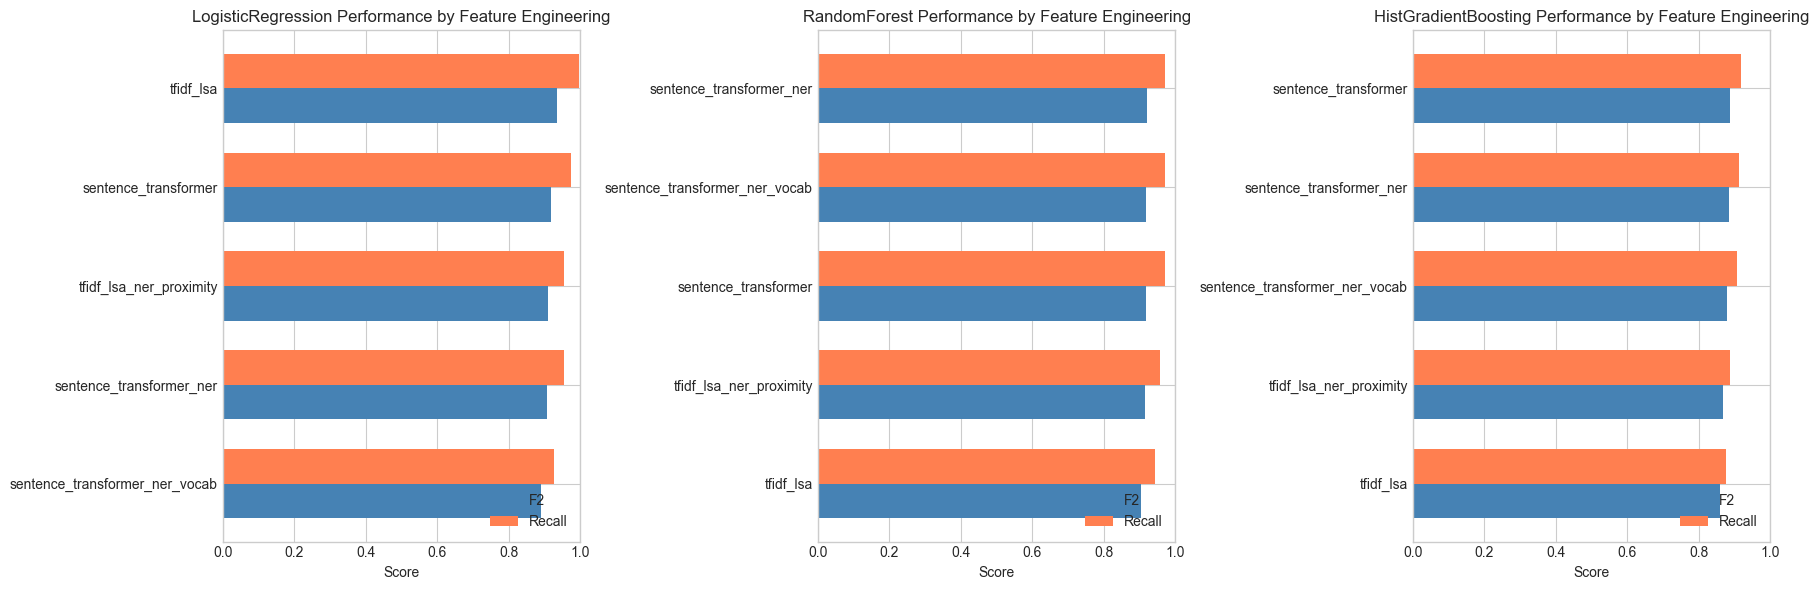

In [19]:
# Visualize comparison - show both classifiers side by side
plot_fe_comparison(fe_df, save_path=MODELS_DIR / 'ep_fe_comparison.png')

## 5.1 Feature Transformer Hyperparameter Tuning

Based on the comparison results above, we tune the key hyperparameter for the best-performing feature engineering method.

TUNING LSA_N_COMPONENTS FOR tfidf_lsa

Testing values: [50, 60, 80, 100, 120, 150, 200]
Classifier: HistGradientBoostingClassifier (baseline)
CV: 3-fold stratified

Testing lsa_n_components=50...


  CV F2: 0.8559 (+/- 0.0309)
Testing lsa_n_components=60...


  CV F2: 0.8648 (+/- 0.0107)
Testing lsa_n_components=80...


  CV F2: 0.8646 (+/- 0.0043)
Testing lsa_n_components=100...


  CV F2: 0.8599 (+/- 0.0235)
Testing lsa_n_components=120...


  CV F2: 0.8594 (+/- 0.0194)
Testing lsa_n_components=150...


  CV F2: 0.8478 (+/- 0.0094)
Testing lsa_n_components=200...


  CV F2: 0.8457 (+/- 0.0113)

LSA_N_COMPONENTS TUNING RESULTS
 lsa_n_components    cv_f2  cv_f2_std  cv_recall  cv_precision
               60 0.864758   0.010690   0.879265      0.811428
               80 0.864634   0.004311   0.881890      0.801988
              100 0.859865   0.023534   0.876640      0.798863
              120 0.859398   0.019446   0.879265      0.788193
               50 0.855860   0.030931   0.871391      0.800111
              150 0.847808   0.009448   0.868766      0.773442
              200 0.845727   0.011291   0.866142      0.772909

Optimal lsa_n_components: 60
Best CV F2: 0.8648
Default (100) CV F2: 0.8599
Improvement: +0.49%
Figure saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/images/ep_tuning_tfidf_lsa.png


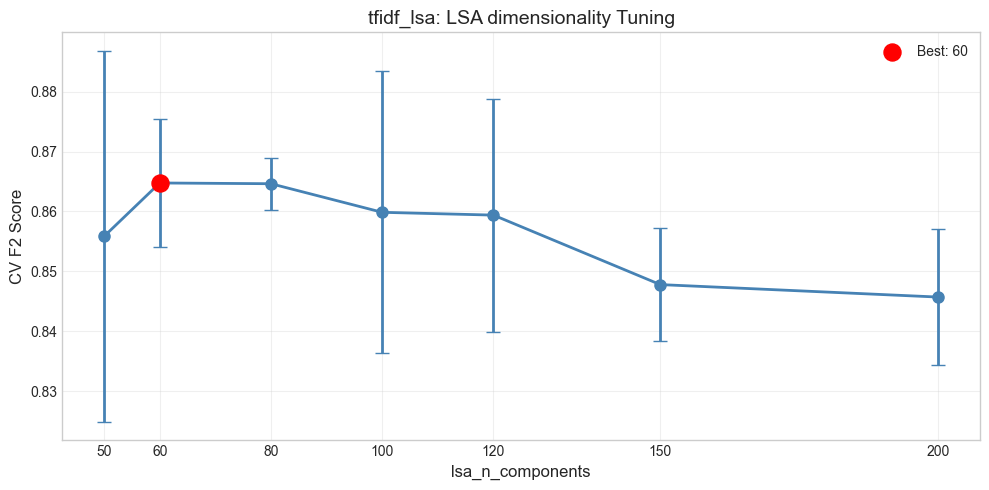

In [20]:
# Choose the baseline classifier to use
baseline_clf = classifiers['HistGradientBoosting']['model']

# Check if tuning configuration exists for the best method
if best_fe in TUNING_CONFIGS:
    tuning_config = TUNING_CONFIGS[best_fe]
    param_name = tuning_config['param_name']
    param_values = tuning_config['param_values']
    description = tuning_config['description']
    
    print("=" * 70)
    print(f"TUNING {param_name.upper()} FOR {best_fe}")
    print("=" * 70)
    print(f"\nTesting values: {param_values}")
    print(f"Classifier: HistGradientBoostingClassifier (baseline)")
    print(f"CV: {N_FOLDS}-fold stratified\n")
    
    tuning_df = tune_feature_transformer(
        transformer_class=EPFeatureTransformer,
        base_config=fe_configs[best_fe],
        param_name=param_name,
        param_values=param_values,
        X_train=X_train,
        y_train=y_train,
        classifier=baseline_clf,
        cv=cv,
        scorer=f2_scorer,
        random_state=RANDOM_STATE,
    )
    
    print("\n" + "=" * 70)
    
    # Analyze tuning results and select best hyperparameter value
    if tuning_df is not None:
        default_value = fe_configs[best_fe].get(param_name)
        
        optimal_param_value, best_tuned_f2 = analyze_tuning_results(
            tuning_df=tuning_df,
            param_name=param_name,
            default_value=default_value,
        )
        
        # Plot the tuning results
        plot_tuning_results(
            tuning_df=tuning_df,
            param_name=param_name,
            param_values=param_values,
            optimal_param_value=optimal_param_value,
            method_name=best_fe,
            description=description,
            save_path=IMAGES_DIR / f'ep_tuning_{best_fe}.png',
        )
    else:
        optimal_param_value = None
else:
    print(f"No tuning configuration defined for {best_fe}")
    print("No tuning was performed.")
    tuning_df = None
    optimal_param_value = None

## 6. Pipeline Export

Create and export the best feature transformer for use in the model selection notebook.

In [21]:
# Create the best transformer with optimal hyperparameters from tuning
print(f"Selected feature engineering approach: {best_fe}")
print(f"Base configuration: {fe_configs[best_fe]}")

# Create final config with optimal hyperparameters
final_config = fe_configs[best_fe].copy()
if best_fe in TUNING_CONFIGS and optimal_param_value is not None:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    final_config[param_name] = optimal_param_value
    print(f"Optimal {param_name}: {optimal_param_value}")

# Create transformer with best configuration
final_transformer = EPFeatureTransformer(**final_config, random_state=RANDOM_STATE)

# Fit on training data
X_train_final = final_transformer.fit_transform(X_train)
print(f"\nFinal feature shape: {X_train_final.shape}")

# Verify by transforming validation data
X_val_final = final_transformer.transform(X_val)
print(f"Validation feature shape: {X_val_final.shape}")

Selected feature engineering approach: tfidf_lsa
Base configuration: {'method': 'tfidf_lsa', 'max_features': 10000, 'lsa_n_components': 100, 'include_metadata_features': False}
Optimal lsa_n_components: 60



Final feature shape: (522, 60)
Validation feature shape: (174, 60)


In [22]:
# Save the fitted transformer
transformer_path = MODELS_DIR / 'ep_feature_transformer.joblib'
joblib.dump(final_transformer, transformer_path)
print(f"Transformer saved to: {transformer_path}")

# Save configuration for reproducibility
config_path = MODELS_DIR / 'ep_feature_config.json'
final_transformer.save_config(config_path)
print(f"Configuration saved to: {config_path}")

# Also save the comparison results
results_path = MODELS_DIR / 'ep_fe_comparison.json'
with open(results_path, 'w') as f:
    json.dump(fe_results, f, indent=2)
print(f"Comparison results saved to: {results_path}")

Transformer saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_feature_transformer.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_feature_config.json
Comparison results saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_fe_comparison.json


## 7. Summary

In [23]:
print("=" * 60)
print("NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nDataset: {len(df)} articles")
print(f"  - Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"\nClass distribution (training):")
print(f"  - Has ESG: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  - No ESG: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"\nBest Feature Engineering: {best_fe}")
print(f"  - Best Classifier: {best_clf}")
print(f"  - CV F2 Score: {best_row['cv_f2']:.4f}")
print(f"  - Features: {int(best_row['n_features'])}")

# Show tuned hyperparameter if applicable
if best_fe in TUNING_CONFIGS and optimal_param_value is not None:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    print(f"  - Optimal {param_name}: {optimal_param_value}")

print(f"\nArtifacts saved:")
print(f"  - {MODELS_DIR / 'ep_feature_transformer.joblib'}")
print(f"  - {MODELS_DIR / 'ep_feature_config.json'}")
print(f"  - {MODELS_DIR / 'ep_fe_comparison.json'}")
print(f"\nNext: Run ep2_model_selection_tuning.ipynb for model selection and hyperparameter tuning")
print("=" * 60)

NOTEBOOK SUMMARY

Dataset: 870 articles
  - Training: 522 (60.0%)
  - Validation: 174 (20.0%)

Class distribution (training):
  - Has ESG: 381 (73.0%)
  - No ESG: 141 (27.0%)

Best Feature Engineering: tfidf_lsa
  - Best Classifier: LogisticRegression
  - CV F2 Score: 0.9355
  - Features: 100
  - Optimal lsa_n_components: 60

Artifacts saved:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_feature_transformer.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_feature_config.json
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_fe_comparison.json

Next: Run ep2_model_selection_tuning.ipynb for model selection and hyperparameter tuning
